In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.cluster import DBSCAN

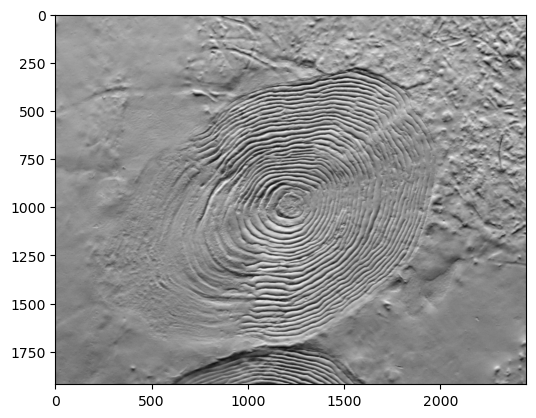

In [2]:
image_path = "data/PSF0001_11b.tif"
image = Image.open(image_path)

# convert to grayscale
grayscale_image = image.convert("L")
image_array = np.array(grayscale_image)

plt.imshow(grayscale_image, cmap="gray")
plt.show()


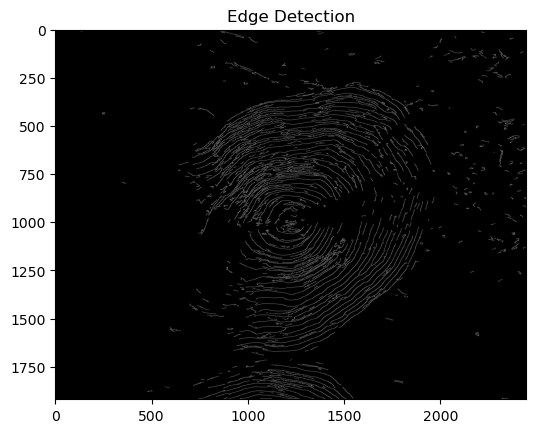

In [3]:
# edge detection using Canny
edges = cv2.Canny(image_array, threshold1=50, threshold2=150)

plt.imshow(edges, cmap="gray")
plt.title("Edge Detection")
plt.show()


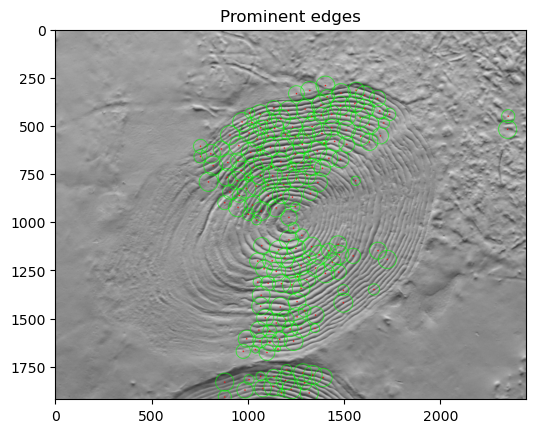

In [4]:
# Hough Circle Transform for center detection - here prominent edge detection
circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, dp=1.5, minDist=50, param1=90, param2=35, minRadius=5,  maxRadius=50)

center_detected_image = cv2.cvtColor(image_array, cv2.COLOR_GRAY2BGR)

if circles is not None:
    circles = np.uint16(np.around(circles))
    for circle in circles[0, :]:
        cv2.circle(center_detected_image, (circle[0], circle[1]), circle[2], (0, 255, 0), 2)
        cv2.circle(center_detected_image, (circle[0], circle[1]), 2, (0, 0, 255), 3)
    center_coords = (circles[0][0][0], circles[0][0][1])
else:
    center_coords = None

plt.imshow(cv2.cvtColor(center_detected_image, cv2.COLOR_BGR2RGB))
plt.title("Prominent edges")
plt.show()

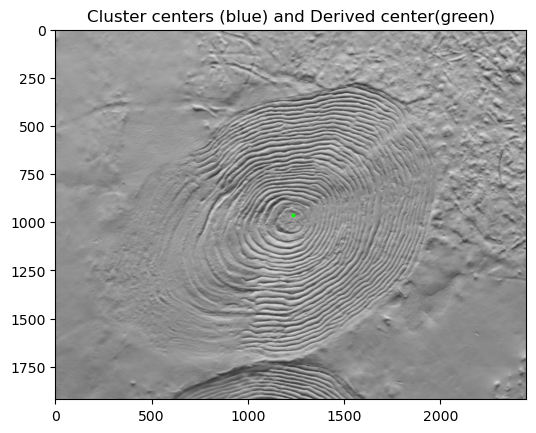

Derived Center Coordinates: (1237, 967)


In [5]:
# Extract circle centers from the detected circles
detected_centers = [(circle[0], circle[1]) for circle in circles[0, :]]
points = np.array(detected_centers)

# Apply DBSCAN clustering to group the circles
dbscan = DBSCAN(eps=1000, min_samples=7)  
labels = dbscan.fit_predict(points)

# Find the unique clusters (ignoring noise labeled as -1)
unique_labels = set(labels) - {-1}
cluster_centers = []

for label in unique_labels:
    cluster_points = points[labels == label]
    centroid = np.mean(cluster_points, axis=0)
    cluster_centers.append(centroid)

# Center = midpoint of all "clusters"
if len(cluster_centers) > 0:
    center_x = int(np.mean([centroid[0] for centroid in cluster_centers]))
    center_y = int(np.mean([centroid[1] for centroid in cluster_centers]))
    final_center = (center_x, center_y)
else:
    final_center = None

cluster_image = cv2.cvtColor(image_array, cv2.COLOR_GRAY2BGR)
for cluster in cluster_centers:
    cv2.circle(cluster_image, (int(cluster[0]), int(cluster[1])), 10, (255, 0, 0), -1)  # Draw cluster centroids
if final_center:
    cv2.circle(cluster_image, final_center, 10, (0, 255, 0), -1)  # Draw final center

plt.imshow(cv2.cvtColor(cluster_image, cv2.COLOR_BGR2RGB))
plt.title("Cluster centers (blue) and Derived center(green)")
plt.show()

# final center coordinates
print("Derived Center Coordinates:", final_center)
